In [73]:
# Step 1: Import Libraries
import pandas as pd  # Pandas for data manipulation
import numpy as np  # NumPy for numerical operations
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMAX model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF and PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose  # Seasonal decomposition
from pmdarima import auto_arima  # Auto ARIMA model selection
from matplotlib import pyplot as plt  # Matplotlib for plotting
from statsmodels.tools.eval_measures import mse, rmse  # Evaluation metrics
from sklearn.model_selection import train_test_split  # Train-test split
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF for multicollinearity
from sklearn.metrics import mean_absolute_error  # MAE for model evaluation
from sklearn.metrics import mean_squared_error  # MSE for model evaluation
import seaborn as sns

In [70]:
# Use the date_format argument in read_csv
df = pd.read_csv('walmart.csv', parse_dates=['Date'], date_format='%d/%m/%y', dayfirst=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Resample to weekly frequency starting on Sundays
df = df.resample('W-SUN').mean()  

In [71]:
# Display information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2019-02-10 to 2021-10-31
Freq: W-SUN
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         143 non-null    float64
 1   Weekly_Sales  143 non-null    float64
 2   Holiday_Flag  143 non-null    float64
 3   Temperature   143 non-null    float64
 4   Fuel_Price    143 non-null    float64
 5   CPI           143 non-null    float64
 6   Unemployment  143 non-null    float64
dtypes: float64(7)
memory usage: 8.9 KB


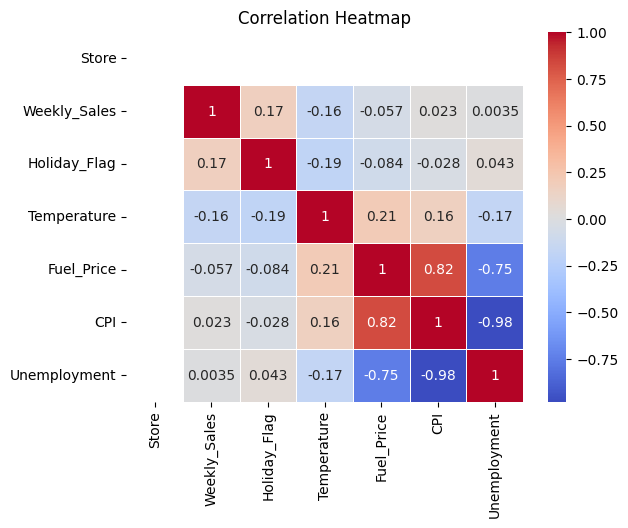

In [74]:
# Correlation heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

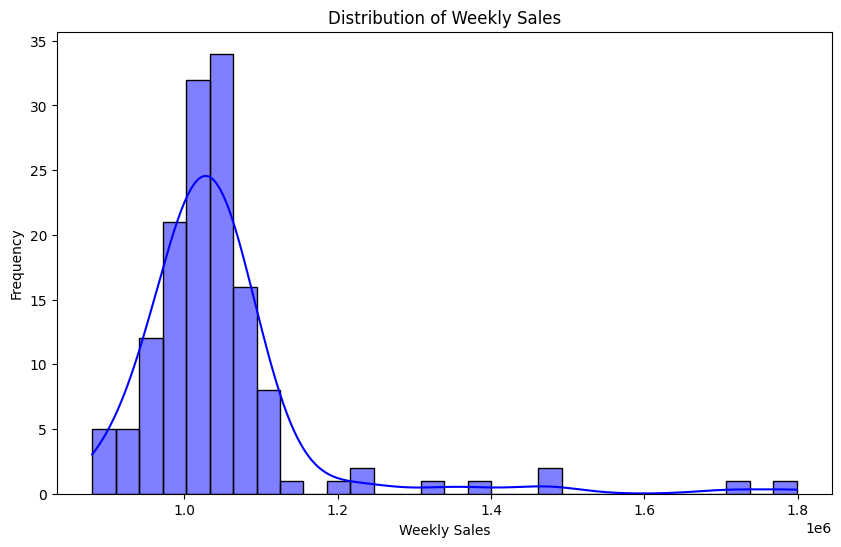

In [75]:
# Distribution of a specific column (e.g., 'Weekly_Sales')
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

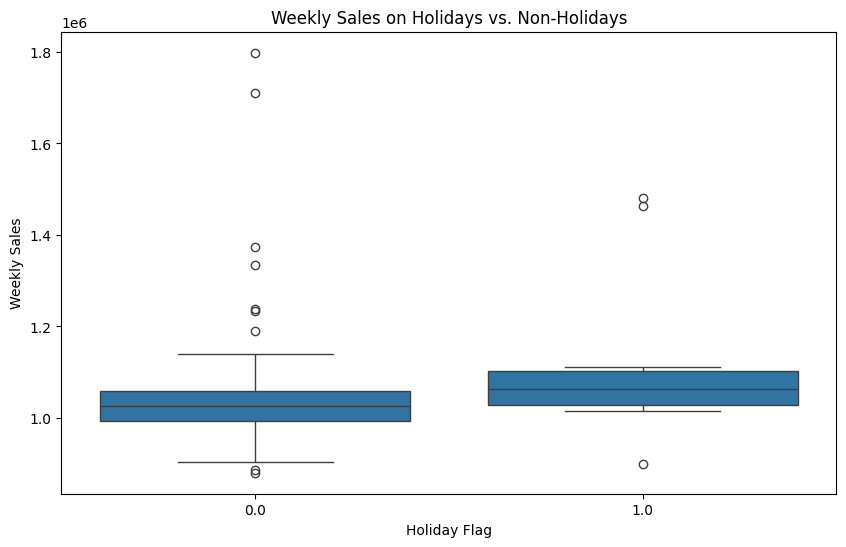

In [76]:
# Boxplot to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Weekly Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.show()

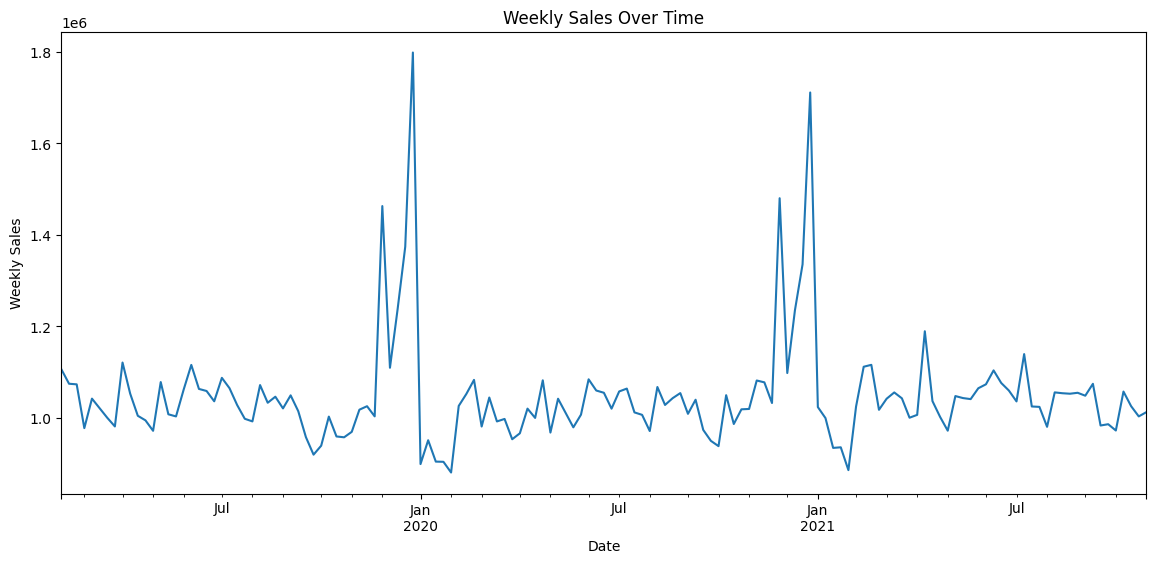

In [77]:
# Step 5: Time Series Plot
# Assuming 'Date' is the index column
plt.figure(figsize=(14, 6))
df['Weekly_Sales'].plot()
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [55]:
print(df.columns)

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')


In [39]:
df.set_index('Date', inplace=True)

In [54]:
df = df.asfreq('W-SUN')  

In [56]:
df = df.sort_index()

In [57]:

train_size = int(len(df) * 0.8)  # 80% for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [58]:
 #Choose external factors for exogenous variables
exog_train = train[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
exog_test = test[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]

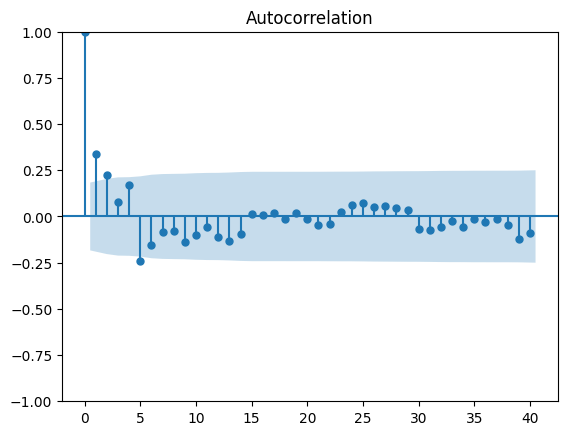

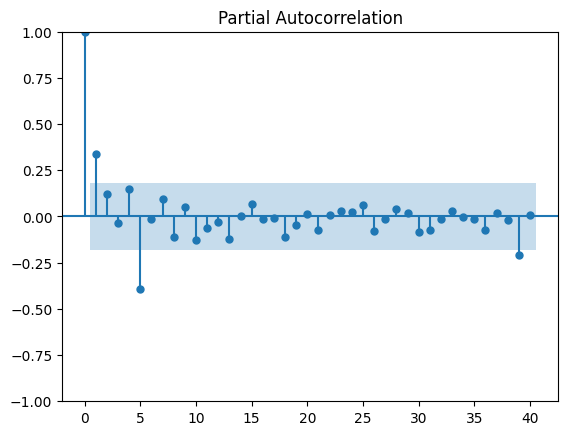

In [61]:

# Plot ACF and PACF
plot_acf(train['Weekly_Sales'], lags=40)
plot_pacf(train['Weekly_Sales'], lags=40)
plt.show()


In [62]:
# Create SARIMAX model with reduced complexity
order = (1, 0, 1)  # Adjust the order as needed
seasonal_order = (0, 0, 0, 0)  # No seasonal ARMA components initially
model = SARIMAX(train['Weekly_Sales'], exog=exog_train, order=order, seasonal_order=seasonal_order, enforce_invertibility=False)

# Fit the model
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31438D+01    |proj g|=  1.00591D-02

At iterate    5    f=  1.31437D+01    |proj g|=  2.99707D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5      9      1     0     0   2.997D-06   1.314D+01
  F =   13.143685765345250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [65]:

mae = mean_absolute_error(test['Weekly_Sales'], mean_forecast)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 34560.03227406716


In [66]:

mse = mean_squared_error(test['Weekly_Sales'], mean_forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 1837287820.2488341


In [67]:
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 42863.59551237897


In [68]:
accuracy = 100 * (1 - mae / test['Weekly_Sales'].mean())
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 96.67%


In [63]:
# Predict on the test set
forecast = results.get_forecast(steps=len(test), exog=exog_test)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

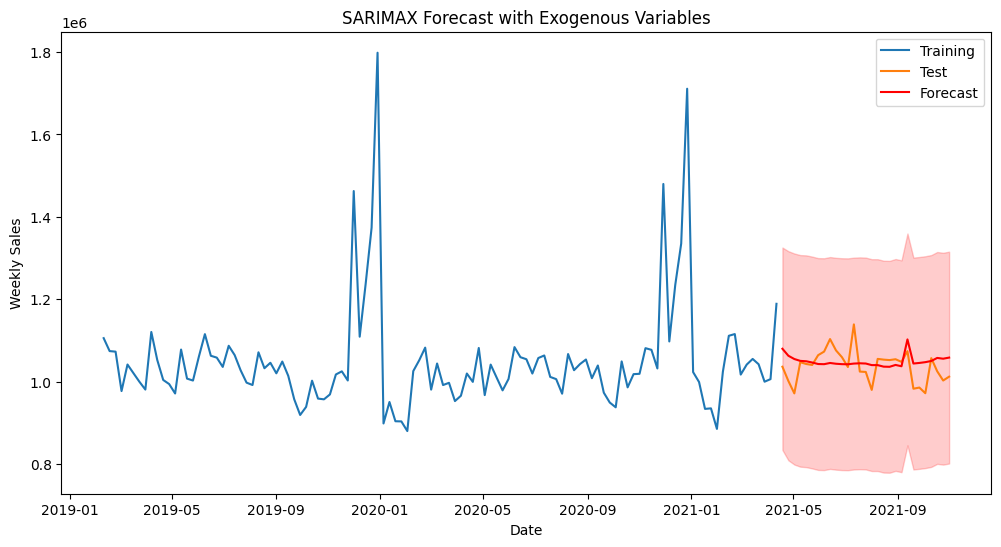

In [64]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Weekly_Sales'], label='Training')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(mean_forecast.index, mean_forecast.values, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2)
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()